In [ ]:
#!pip install climetlab
#!pip install climetlab-maelstrom-radiation

In [1]:
import climetlab as cml
import numpy as np 
import matplotlib.pyplot as plt

# Radiation emulation
### The task
Radiative heating is a crucial physical process in weather and climate models. Solving the governing equations of radiative heating is expensive and as such many approximations or simplifications are made, e.g. radiative heating is often solved on a coarser spatial grid and less frequently in time than other model components. This dataset captures the inputs and outputs to the ecRad McICA scheme (https://github.com/ecmwf/ecrad) enabling users to build emulators of this physical process.
### Why
Accelerating radiation parametrisation would enable it to be run at higher spatial or temporal resolutions or reinvest these savings into other model improvements. 
### The challenge
Emulate radiative heating with a minimal possible MSE while keeping the computational cost as low as possible.


# Loading the data
Data can be loaded by either specifying a **subset**, e.g. 'tier-1' or by specifying the trio of **date, timestep, patch**.
### Subset
Currently 'tier-1' and '2020' are supported values. NB '2020' is huge, O(Tb) so download at your peril. Recommend using 'tier-1' to explore the data.
### Date/timestep/patch
These describe the start **date** of the numerical forecast used to generate the data, the **timestep** index of said forecast (note the time increment is 12 minutes, meaning step 125 corresponds to 25 hours after initialisation) and **patch** a spatial subset of globe (here the globe is divided into 16 equal regions).
Valid values for each of the above can be found with **cmlds.valid_date** etc.
Most start dates are from 2020, which we recommend as the training set, four start dates in 2019 are provided as validation/testing data.
### If no descriptions are passed then tier-1 subset is loaded, corresponding to 2020-01-01/0/range(0,16,2)

In [2]:
cmlds = cml.load_dataset(
        'maelstrom-radiation',subset='tier-1'
    )

By downloading data from this dataset, you agree to the terms and conditions defined at https://git.ecmwf.int/projects/MLFET/repos/maelstrom-radiation/LICENSE If you do not agree with such terms, do not download the data. 
Loading subset: tier-1
Loading date: 20200101, timestep: 0, patch: [0, 2, 4, 6, 8, 10, 12, 14]


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
print(cmlds.valid_date)

['20200101', '20200131', '20200301', '20200331', '20200430', '20200530', '20200629', '20200729', '20200828', '20200927', '20201027', '20201126', '20201226', '20190131', '20190531', '20190829', '20191028']


# Exploring the data
The dataset object supports the **to_xarray** method, which produces an xarray handle on the dataset. 

In [4]:
arrays = cmlds.to_xarray()

Data comes in 4 shapes:
1. Single level data, which has one dimension the column, where each column is a separate example for the machine learning.
2. Model levels, e.g. q (speicific humidity), [column,137] shape, describing the field on each model level in the column.
3. Half levels, e.g. temperature_hl, [column,138] shape, the interfaces and boundaries to each of the 137 model levels in the atmospheric model. Often used within the current model code to calculate vertical derivatives.
4. Interfaces, **only** overlap_param, like half-levels but without boundary information.

In [5]:
print(arrays['solar_irradiance'])

<xarray.DataArray 'solar_irradiance' (column: 135680)>
array([1406.9596, 1406.9596, 1406.9596, ..., 1406.9596, 1406.9596,
       1406.9596], dtype=float32)
Dimensions without coordinates: column
Attributes:
    long_name:  Solar irradiance at Earth's orbit
    units:      W m-2


In [6]:
print(arrays['q'])

<xarray.DataArray 'q' (column: 135680, level: 137)>
dask.array<concatenate, shape=(135680, 137), dtype=float32, chunksize=(16960, 137), chunktype=numpy.ndarray>
Dimensions without coordinates: column, level
Attributes:
    long_name:  Specific humidity
    units:      1


In [7]:
print(arrays['temperature_hl'])

<xarray.DataArray 'temperature_hl' (column: 135680, half_level: 138)>
dask.array<concatenate, shape=(135680, 138), dtype=float32, chunksize=(16960, 138), chunktype=numpy.ndarray>
Dimensions without coordinates: column, half_level
Attributes:
    long_name:  Temperature
    units:      K


In [8]:
print(arrays['overlap_param'])

<xarray.DataArray 'overlap_param' (column: 135680, level_interface: 136)>
dask.array<concatenate, shape=(135680, 136), dtype=float32, chunksize=(16960, 136), chunktype=numpy.ndarray>
Dimensions without coordinates: column, level_interface
Attributes:
    long_name:  Cloud overlap parameter
    units:      1


## What variables are there?

In [9]:
for key in arrays:
    print(key)

solar_irradiance
lat
lon
skin_temperature
cos_solar_zenith_angle
sw_albedo
sw_albedo_direct
lw_emissivity
iseed
pressure_hl
temperature_hl
q
o3_mmr
co2_vmr
n2o_vmr
ch4_vmr
o2_vmr
cfc11_vmr
cfc12_vmr
hcfc22_vmr
ccl4_vmr
cloud_fraction
q_liquid
q_ice
re_liquid
re_ice
overlap_param
fractional_std
inv_cloud_effective_size
aerosol_mmr
flux_dn_sw
flux_up_sw
flux_dn_lw
flux_up_lw
hr_sw
hr_lw


## Quite a lot of variables!
Of the above, the last 6 capture the outputs of radiative heating, namely the heating fluxes and heating rates. Each is divided into  short-wave (sw, solar) and long-wave (lw) components, with the fluxes further divided into downwards and upwards fluxes. Fluxes are described on half-levels. The heating rates are derived from the fluxes by calculating the net flux and calculating the gradient of net flux with respect to pressure. Mathematically this is:

Heating_rate[i] = - g/c_p * (flux_dn[i] + flux_up[i] - flux_dn[i+1] - flux_up[i+1]) / (hl_pressure[i] - hl_pressure[i+1])

The many inputs describe the state of the atmosphere, including the humidity, aerosol concentrations, solar irradiance and fraction of the grid box that is cloud.

Several of the varibles: 

lat, lon, iseed

are not used by the current model and therefore should have limited predictive power. 

A few of the variables are independent of time and horizontal space in the scope of this dataset, and could therefore be dropped. This includes some of the aerosol mixing ratios.

## What should I predict

The current model directly predicts fluxes and then the heating rates are derived using the above formula. The heating rates, plus fluxes at the boundaries (surface and top of atmosphere) are the fields actually used in the evolution of the weather/climate model. Previous work has identified some stability issues with deriving the heating rates from machine learning models of fluxes, this can be partially understood by looking at a profile of pressure and seeing that this field (the denominator in the above expression) varies by several orders of magnitude.

We therefore suggested a curate set of outputs, which can be accessed by creating the dataset as below, with **minimal_outputs = True**

In [10]:
cmlds = cml.load_dataset(
        'maelstrom-radiation',subset='tier-1',minimal_outputs=True
    )
arrays = cmlds.to_xarray()
print(arrays['hr_sw'])
print(arrays['fluxes_sw'])

Loading subset: tier-1
Loading date: 20200101, timestep: 0, patch: [0, 2, 4, 6, 8, 10, 12, 14]


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

<xarray.DataArray 'hr_sw' (column: 135680, level: 137)>
dask.array<truediv, shape=(135680, 137), dtype=float32, chunksize=(16960, 137), chunktype=numpy.ndarray>
Dimensions without coordinates: column, level
<xarray.DataArray 'fluxes_sw' (column: 135680, boundaries: 3)>
dask.array<concatenate, shape=(135680, 3), dtype=float32, chunksize=(16960, 1), chunktype=numpy.ndarray>
Dimensions without coordinates: column, boundaries
Attributes:
    long_name:  Downwelling shortwave flux
    units:      W m-2


this extracts only the minimal required fluxes from the boundaries (flux upwards at top of atmosphere + fluxes downwards and upwards at the surface) in combination with heating rates. 

You could also start by attempting to only predict the sw or lw components, these are solved separately in the existing model but there may be economies of scale in predicting both together.

## That's a lot of input predictors
Agreed! But they are theoretically necessary, if you want a different view of the inputs you can use:

In [11]:
cmlds = cml.load_dataset(
        'maelstrom-radiation',subset = 'tier-1',minimal_outputs = True,
        raw_inputs = False,
    )
arrays = cmlds.to_xarray()
print(arrays)

Loading subset: tier-1
Loading date: 20200101, timestep: 0, patch: [0, 2, 4, 6, 8, 10, 12, 14]


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:       (boundaries: 3, col_variable: 27, column: 135680, half_level: 138, hl_variable: 2, inter_variable: 1, level: 137, level_interface: 136, p_variable: 1, sca_variable: 17)
Dimensions without coordinates: boundaries, col_variable, column, half_level, hl_variable, inter_variable, level, level_interface, p_variable, sca_variable
Data variables:
    sca_inputs    (column, sca_variable) float32 dask.array<chunksize=(16960, 1), meta=np.ndarray>
    col_inputs    (column, level, col_variable) float32 dask.array<chunksize=(16960, 137, 1), meta=np.ndarray>
    hl_inputs     (column, half_level, hl_variable) float32 dask.array<chunksize=(16960, 138, 1), meta=np.ndarray>
    pressure_hl   (column, half_level, p_variable) float32 dask.array<chunksize=(16960, 138, 1), meta=np.ndarray>
    inter_inputs  (column, level_interface, inter_variable) float32 dask.array<chunksize=(16960, 136, 1), meta=np.ndarray>
    fluxes_sw     (column, boundaries) float32 dask.array<chun

here we have gathered variables of equivalent shape together into 5 input arrays:
scalar inputs, column inputs (on model levels), half-level (hl) inputs, interface level inputs and hl pressure.
hl pressure features both in the hl_inputs and hl_pressure, in case users want to normalise the values in hl_inputs but still pass the hl_pressure field for internal use in calculating the heating rate.

If you want to see in what order these are packed, you can see this by looking at 

In [12]:
print(cmlds.isca_keys)
print(cmlds.icol_keys)
print(cmlds.ihl_keys)
print(cmlds.iinter_keys)

['skin_temperature', 'cos_solar_zenith_angle', 'sw_albedo', 'sw_albedo_direct', 'lw_emissivity', 'solar_irradiance']
['q', 'o3_mmr', 'co2_vmr', 'n2o_vmr', 'ch4_vmr', 'o2_vmr', 'cfc11_vmr', 'cfc12_vmr', 'hcfc22_vmr', 'ccl4_vmr', 'cloud_fraction', 'aerosol_mmr', 'q_liquid', 'q_ice', 're_liquid', 're_ice']
['temperature_hl', 'pressure_hl']
['overlap_param']


# Machine learning this dataset
We provide two views of this dataset, the first is describe above and is the best venue for exploring the dataset. For machine learning efficiently you may find the many variables are not stored efficiently so we provide another method. We have shuffled and rewritten the above data into the TFRecord format (https://www.tensorflow.org/tutorials/load_data/tfrecord) the data has been packaged into input groups described above. We can download and use this data in the following way.

In [13]:
cmlds_tf = cml.load_dataset(
        'maelstrom-radiation-tf',subset = 'tier-1'
    )
#Note that because the TFRecord version of the dataset has been shuffled, the 'tier-1' 
#version is not the same examples as the 'tier-1' subset of the radiation dataset.

print(cmlds_tf.documentation)

By downloading data from this dataset, you agree to the terms and conditions defined at https://git.ecmwf.int/projects/MLFET/repos/maelstrom-radiation/LICENSE If you do not agree with such terms, do not download the data. 
Minimal call:
cml.load_dataset('maelstrom-radiation-tf') 
Optional arguments:
Specify subset, subset = 'tier-1' (NB different subset to raw radiation)
Or specify timestep/filenum
Valid values found in .valid_timstep etc
To remove items from input/outputs change input_fields/output_fields
e.g. ouput_fields = ['sw','hr_sw'] to build a model only predicting the sw heating
To normalise the input data using the mean/std from the whole 2020 dataset use, norm = True
To reduce to minimal output components, minimal_outputs = True 



The main method on the maelstrom-radiation-tf dataset is **to_tfdataset**, which produces a Tensorflow dataset object.
These can be passed to Keras' **.fit** or be iterated over directly as below.

In [14]:
tfds = cmlds_tf.to_tfdataset(batch_size=256,repeat=False)

In [15]:
for i,(inputs,outputs) in enumerate(tfds):
    if i%10==0:
        print(i)
print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
264


the **tier-1** dataset contains 67,584 examples or 264 batches of 256. **NB** the tier-1 subset does not correspond to the same subset used in the `maelstrom-radiation` dataset (due to the shuffling).
Examining a batch of data, this is a tuple of inputs and outputs. The inputs correspond to the groups of equal shaped variables described above. For the outputs, the only difference is that the down and up fluxes have been concatenated together (in order downwards, upwards).

In [16]:
print(inputs.keys())
print(outputs.keys())

dict_keys(['sca_inputs', 'col_inputs', 'hl_inputs', 'inter_inputs', 'pressure_hl'])
dict_keys(['sw', 'lw', 'hr_sw', 'hr_lw'])


## What should I use?
We've presented many options of data variations. We suggest using the TFRecords dataset and the settings below, which normalise the input arrays (using elemental mean and standard deviation from the complete 2020 catelogue) and create a minimal output predictors corresponding to the fluxes as the boundaries plus the heating rates. If you have the disk space, consider downloading (many!) more TFRecord files.

In [17]:
cmlds_tf = cml.load_dataset(
        'maelstrom-radiation-tf',subset = 'tier-1',norm = True, minimal_outputs = True
    )
tfds = cmlds_tf.to_tfdataset(batch_size=256,repeat=False)

Loading normalisation arrays


  0%|          | 0/5 [00:00<?, ?it/s]

## Machine learning example
Below we will design a dense feed-forward architecture which will predict 4 variables, the boundary fluxes and heating rate profiles of both shortwave and longwave heating.

In this example we have a mismatch between the number of degrees of freedom and the number of training examples, so we might expect overfitting.

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense,Concatenate,Input
from tensorflow import nn
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def densenet_minimal(inp_spec,width=256,depth=5):
    #Assume inputs have the order
    #scalar, column, hl, inter, pressure_hl
    kw = 5 
    all_inp = []
    for k in inp_spec.keys():
        all_inp.append(Input(inp_spec[k].shape[1:],name=k))
    
    col_inp = Flatten()(all_inp[1])
    hl_inp = Flatten()(all_inp[2])
    inter_inp = Flatten()(all_inp[3])
    hl_p = all_inp[-1]
    flat_p = Flatten()(hl_p)
    dense = Concatenate(axis=-1)([all_inp[0],col_inp,hl_inp,inter_inp])
    # dense = BatchNormalization()(dense)
    for i in range(depth):
        dense = Dense(width,activation=nn.swish)(dense)

    dense_sw = Dense(width//2,activation=nn.swish)(dense)
    dense_lw = Dense(width//2,activation=nn.swish)(dense)

    sw = Dense(3,activation='linear',name='sw')(dense_sw)
    hr_sw = Dense(137,activation='linear',name='hr_sw')(dense_sw)

    lw = Dense(3,activation='linear',name='lw')(dense_lw)
    hr_lw = Dense(137,activation='linear',name='hr_lw')(dense_lw)

    return all_inp,[sw,hr_sw,lw,hr_lw]


**Note** below you will see that we have an imbalance in the values of the boundary fluxes (dubbed sw and lw) and the heating rates. To combat this we use **large loss weights** on the heating rate terms.

In [19]:
(inputs,outputs) = densenet_minimal(tfds.element_spec[0])
losses = {'sw':'mse','lw':'mse','hr_sw':'mse','hr_lw':'mse'}
loss_weights=[1,1,10000,10000]
mod= Model(inputs=inputs,outputs=outputs)
opt = Adam(10**(-4))
mod.compile(loss=losses, optimizer=opt,loss_weights=loss_weights)
mod.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
col_inputs (InputLayer)         [(None, 137, 27)]    0                                            
__________________________________________________________________________________________________
hl_inputs (InputLayer)          [(None, 138, 2)]     0                                            
__________________________________________________________________________________________________
inter_inputs (InputLayer)       [(None, 136, 1)]     0                                            
__________________________________________________________________________________________________
sca_inputs (InputLayer)         [(None, 17)]         0                                            
______________________________________________________________________________________________

In [20]:
for epoch in range(100):
    mod.fit(tfds)

265/265 [==============================] - 6s 24ms/step - loss: 155977.4836 - sw_loss: 1101.9276 - hr_sw_loss: 0.0476 - lw_loss: 15.4468 - hr_lw_loss: 0.0408


In [28]:
takends = tfds.take(1)
for inputs,outputs in takends:
    train_pred = mod.predict(inputs)

## Visualising training results
Predictions on the heating rates (see sw plotted below) are bad, but predictions on the boundary fluxes are generally good.

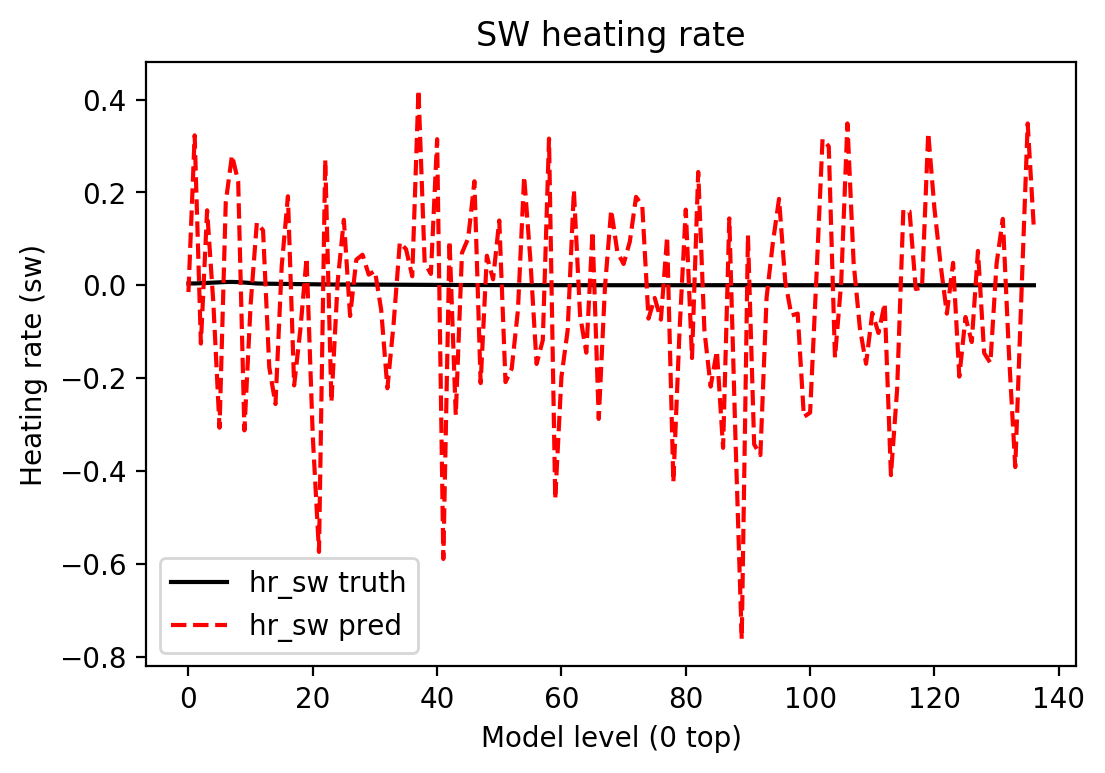

In [30]:
idx = 0
plt.figure(dpi=200)
plt.title('SW heating rate')
plt.plot(outputs['hr_sw'][0,:],'k',label='hr_sw truth')
plt.plot(train_pred[1][0,:],'r--',label = 'hr_sw pred')
plt.xlabel('Model level (0 top)')
plt.ylabel('Heating rate (sw)')
plt.legend()

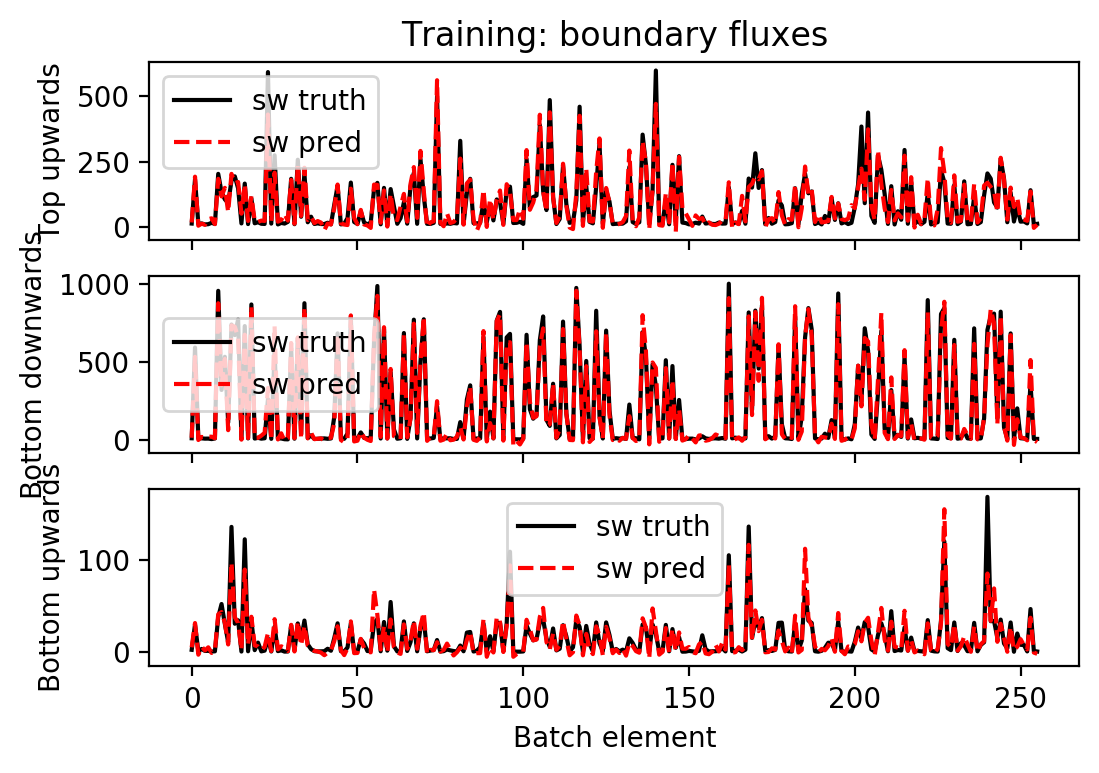

In [23]:
idx = 0
plt.figure(dpi=200)
ylabels= ['Top upwards', 'Bottom downwards', 'Bottom upwards']
for i in range(3):
    ax=plt.subplot(3,1,i+1)
    if i==0:
        plt.title("Training: boundary fluxes")

    plt.plot(np.arange(256),outputs['sw'][:,i].numpy(),'k',label='sw truth')
    plt.plot(np.arange(256),train_pred[0][:,i],'r--',label = 'sw pred')
    if i==2:
        plt.xlabel('Batch element')
    else:
        ax.set_xticklabels('')
    plt.ylabel(ylabels[i])
    plt.legend()

## Validating the results
We suggest using all of 2020 for training. As independent testing data users can similarly access data from 2019. Examining valid_timestep we see 4 timesteps corresponding to dates in 2019. For these timesteps there are a larger number of possible filenum (0-115). If you have a large amount of disk space all the filenums can be downloaded simulatenous by using 

`cml.load_dataset('maelstrom-radiation-tf',subset='2019053100')`

Note this will use ~120Gb of space.

For a smaller set, you can use the below:

In [24]:
print("Timesteps: ",cmlds_tf.valid_timestep)
print("Subsets: ",cmlds_tf.valid_subset)
cmlds_tf_valid = cml.load_dataset(
        'maelstrom-radiation-tf',timestep=2019053100,filenum=0,norm = True, minimal_outputs = True
    )
tfds_valid = cmlds_tf_valid.to_tfdataset(batch_size=256,repeat=False)

Timesteps:  [0, 125, 250, 375, 500, 625, 750, 875, 1000, 1125, 1250, 1375, 1500, 1625, 1750, 1875, 2000, 2125, 2250, 2375, 2500, 2625, 2750, 2875, 3000, 3125, 3250, 3375, 3500, 2019013100, 2019053100, 2019082900, 2019102800]
Subsets:  ['tier-1', '2020', '2019013100', '2019053100', '2019082900', '2019102800']
Loading normalisation arrays


  0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
takends = tfds_valid.take(1)
for inputs,outputs in takends:
    train_pred = mod.predict(inputs)

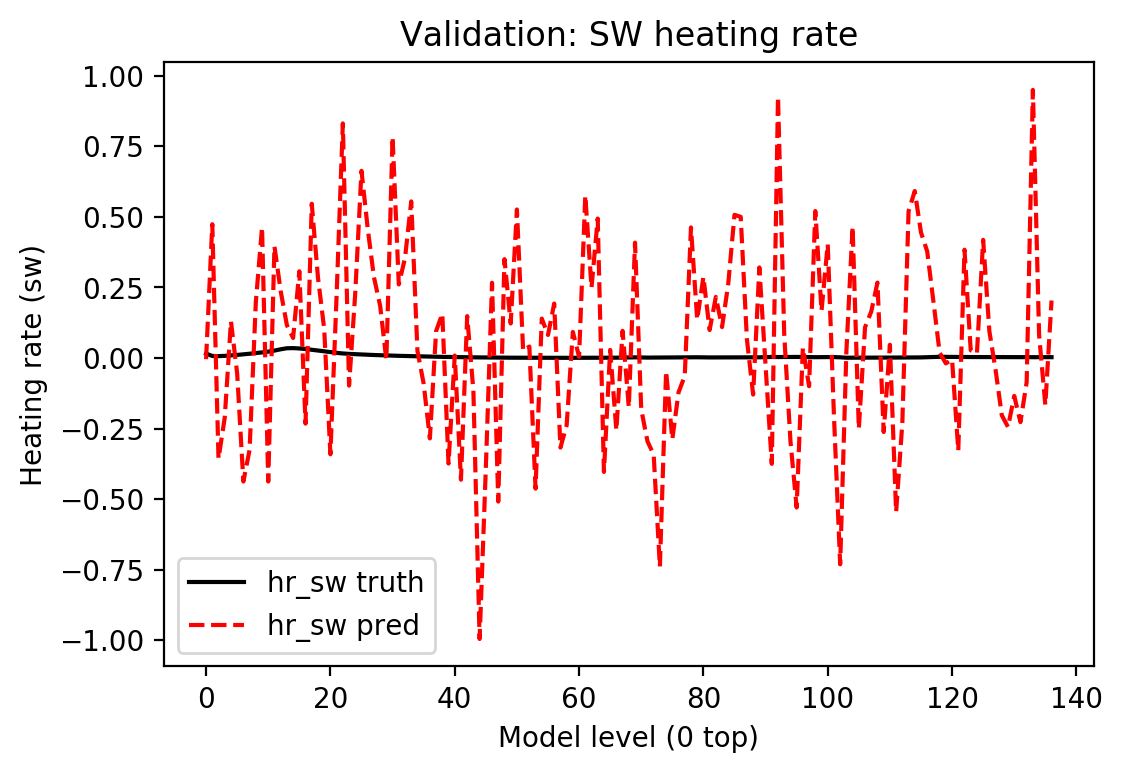

In [26]:
idx = 0
plt.figure(dpi=200)
plt.title('Validation: SW heating rate')
plt.plot(outputs['hr_sw'][0,:],'k',label='hr_sw truth')
plt.plot(train_pred[1][0,:],'r--',label = 'hr_sw pred')
plt.xlabel('Model level (0 top)')
plt.ylabel('Heating rate (sw)')
plt.legend()

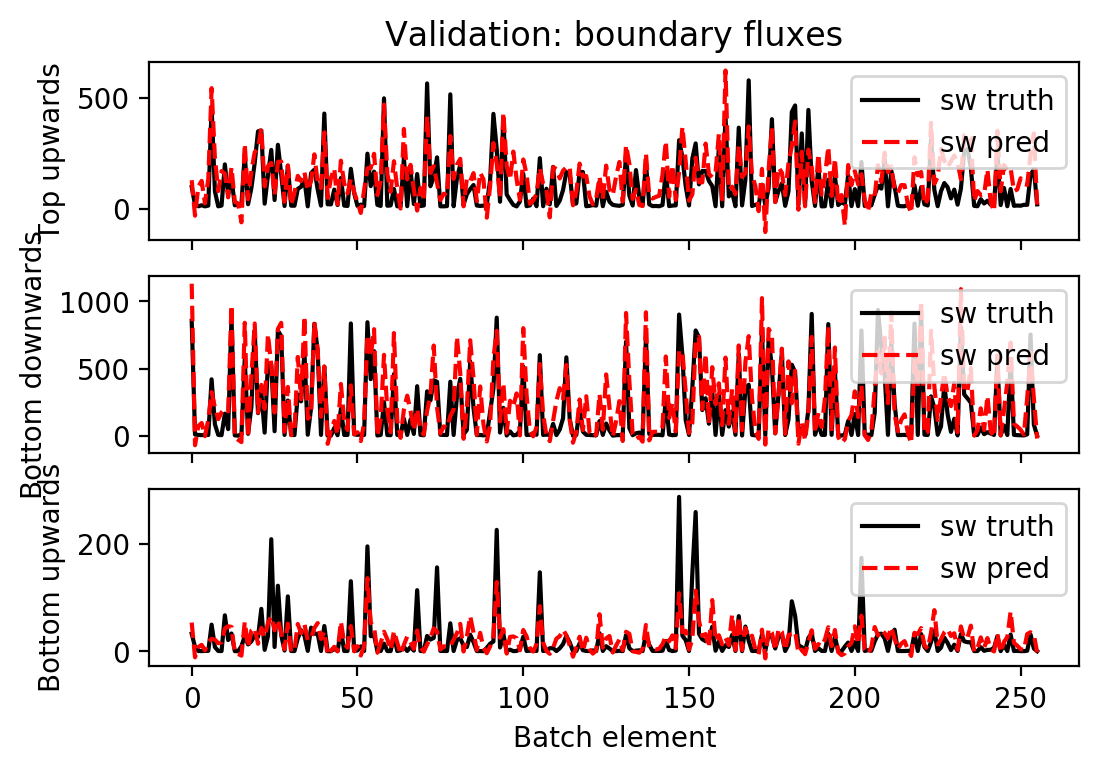

In [27]:
idx = 0
plt.figure(dpi=200)
colours= ['r','g','b']
ylabels= ['Top upwards', 'Bottom downwards', 'Bottom upwards']
for i in range(3):
    ax=plt.subplot(3,1,i+1)
    if i==0:
        plt.title("Validation: boundary fluxes")

    plt.plot(np.arange(256),outputs['sw'][:,i].numpy(),'k',label='sw truth')
    plt.plot(np.arange(256),train_pred[0][:,i],'r--',label = 'sw pred')
    if i==2:
        plt.xlabel('Batch element')
    else:
        ax.set_xticklabels('')
    plt.ylabel(ylabels[i])
    plt.legend()

Predictions on the heating rate remain bad, but predictions on the boundary fluxes are ok, but worse than for the training dataset (this is expected because of overfitting a small dataset).
# Summary
## Data
Two ways to play, either **maelstrom-radiation** or **maelstrom-radiation-tf**, the former is good for understanding the structure and complexity of the data, the latter offers rapid access to a shuffled version of the dataset.
### Recommended approach, try to predict the minimal_output setup which includes heating rates and boundary fluxes, sw & lw could be considered separately.
## Modelling challenges
1. Large number of inputs
2. Mismatch in magnitudes of predictands.

## Your challenge, minimise the combined losses while making the computationally cheapest network.

